<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <h1 style="color:#00797C;padding-bottom:0px">Change of Support and the Volume Variance Relation</h1>
    <h2 style="color:#00797C;padding-bottom:20px">A Companion Notebook to Geostatistics Lessons</h2>    
</div>

<p class="author" style="padding: 0;"><center><b>Haoze Zhang and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>January 9, 2025</b></center></p>

---

The following notebook provides a demonstration of the theory presented in [Change of Support and the Volume Variance Relation](https://geostatisticslessons.com/lessons/changeofsupport). Understanding how a grade distribution will change as it is scaled to a larger support is a critical component of assessing recoverable resources. This notebook demonstrates how the variogram continuity and block size impacts the predicted block-scale distribution.

1. **Load and Decluster Data**
    - Load copper example data
    - Use declustering to construct a representative point-scale distribution for input the next steps

2. **Impact of Continuity on Block Distribution**
    - Generate variograms with varying continuity
    - Calculate the block-scale distribution using a discrete Gaussian model (DGM) for each variogram
    - Compare the point- and block-scale distributions to understand the impact of changing continuity

3. **Impact of Block Size on Block Distribution**
    - Define various block sizes to test
    - Calculate the block-scale distribution using a DGM for each block size
    - Compare the point- and block-scale distributions to understand the impact of changing block sizes

As concepts presented here extend to virtually all mineral deposits, users may extend this notebook to rapidly test the expected impact of parameters on a domain's block-scale grade distribution (e.g., understand the impact of an uncertain nugget effect, or differing selective mining unit scales under consideration).

---

Import required packages:

In [ ]:
import matplotlib.pyplot as plt
import rmsp

Define plotting parameters and a wrapper function used in figure generation that follows. Note that this cell is placed here since it may otherwise distract from essential steps that follow. It can therefore **be ignored unless readers are experimenting and altering, as no key calculations are performed.**

In [2]:
# 3D viewing parameters
rmsp.GlobalParams['plotting.viewer3d.figsize_show_static'] = (6, 6)

# Parameters used repeatedly in plotting histograms and KDE densities
kdepars = dict(bin_type='density', stats=['mean', 'variance'],
               stats_ha='left', stats_loc=(0.02, 0.98), num_bin=20,
               histlim=(0.01, 15))
histpars = kdepars.copy()
histpars.update(dict(log=True, xlim=(0.01, 15)))

def plot_point_vs_block_dists(point_dist, block_dist, title, ax, ylim):
    """Function repeatedly used for comparing point and block scale distributions"""
    pars = kdepars.copy()
    pars.update({'stats_label': 'Point Dist.', 'stats_c': 'C3', 'alpha': 0.0})
    point_dist.plot(cdf=False, unistats=True, title=title, unistats_kwargs=pars, ax=ax)
    pars = histpars.copy()
    pars.update({'stats_label': 'Block Dist.', 'stats_loc': (0.3, 0.98)})
    block_dist.histplot(**pars, ax=ax)
    ax.set_ylim(0, ylim)

---
# Load and Decluster Data

This section loads example data and declusters it to form the representative point-scale distribution, which is input to the DGM in subsequent sections.

To begin, load and visualize a small copper dataset:

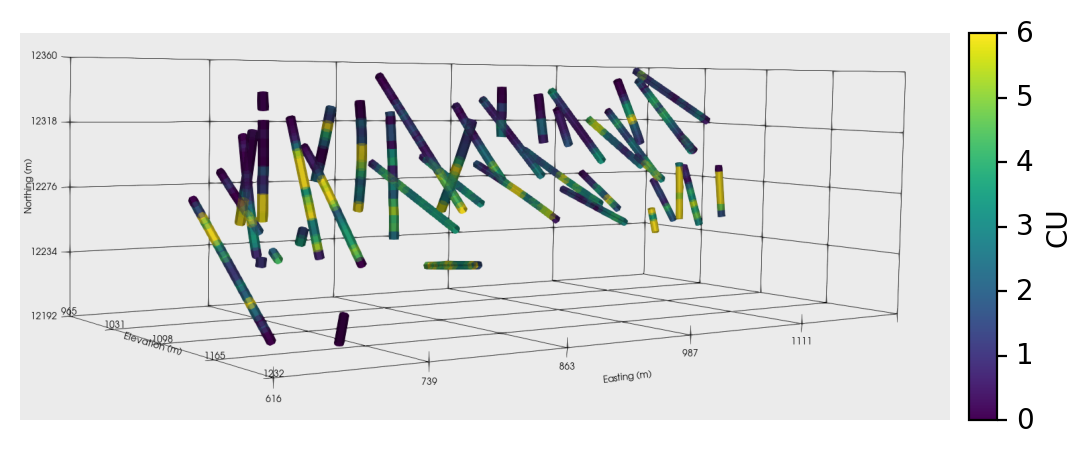

In [3]:
data = rmsp.load_example_data('copper_composite')

viewer = data.view3d('CU', representation='Surface', clim=(0, 6))
viewer.set_camera(view_matrix=[151.57,12359.40,2052.05,863.61,12276.59,1098.32,0.03,1.00,-0.07])
_ = viewer.show_static(axis_kws=True)

Cell declustering is used here to generate representative weights. In practice, you may wish to consider nearest neighbour or inverse distance declustering so that estimation/simulation domain geometries are incorporated. Cell declustering is generally initialized with the diagnostic plot generated below, providing insight into how the declustered mean varies with cell size.

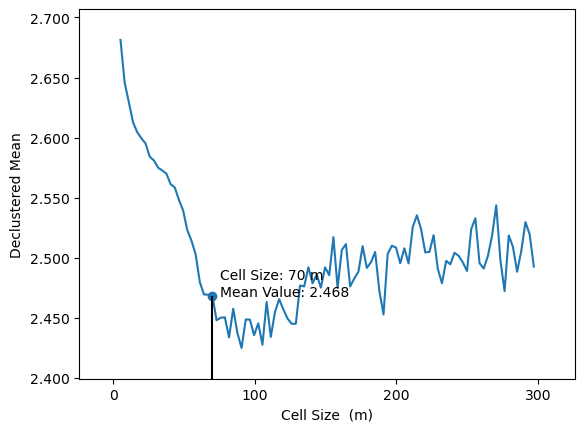

In [4]:
declus = rmsp.DeclusterCell(num_origins=500)
sizes, wts = declus.decluster_over_range(data, 'CU', num_cells=100, min_size=5, max_size=300)

cell_size = 70   # choose this cell size based on data spacing and diagnostic
fig = declus.plot(chosen_size=cell_size)

Using the cell size chosen/highlighted above, perform final declustering to generate weights used in distribution calculations that follow. Compare the clustered and declustered grade distributions.

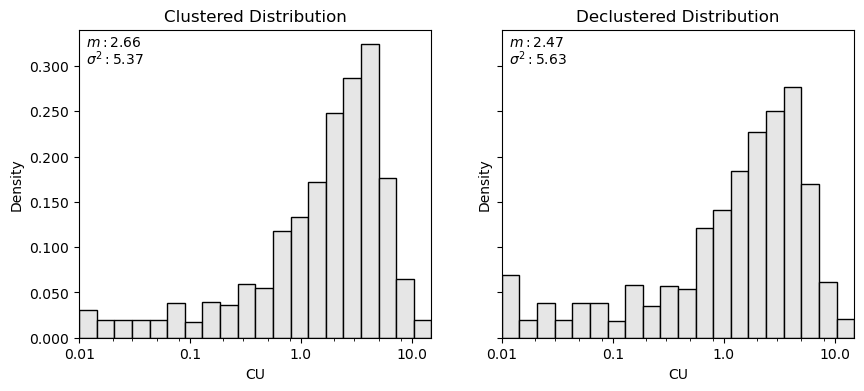

In [5]:
data['wt'] = declus.decluster(data, 'CU', cell_size)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
data.histplot('CU', title='Clustered Distribution', ax=axes[0], **histpars)
data.histplot('CU', 'wt', title='Declustered Distribution', ax=axes[1], **histpars)

The declustered point-scale distribution (right distribution above) is fit with a kernel density estimation (KDE) to simplify visualization (overlaying) against block-scale distributions that follow in the next section. Observe that a PDF of the KDE represents a reasonable fit of the histogram.

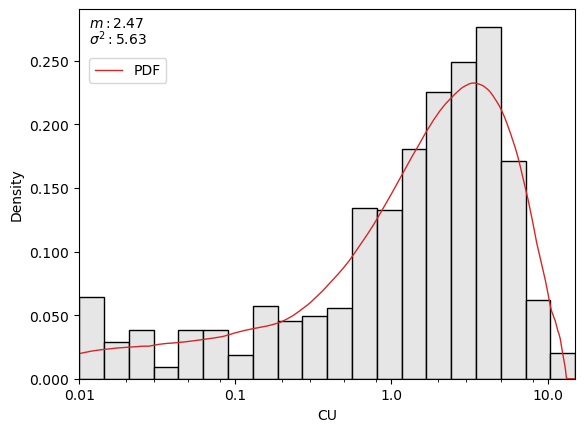

In [6]:
point_dist = rmsp.UnivariateKDE(data, "CU", wt="wt", log=True)
fig, ax = point_dist.plot(cdf=False, xlim=histpars['xlim'], unistats_kwargs=kdepars)
_ = ax.legend(loc=(0.02, 0.8))

---
# Impact of Continuity on Block Distribution

The impact of continuity on block distributions is demonstrated in this section. **In practice, the variogram model would be fit to the directional experimental variogram of the domain.** Mimicking the Geostatistics Lesson presentation, simple omni-directional variogram models (widely scaled to differing continuities) are used here for simplicity.

Begin by creating a list of variogram models that vary from high nugget effect and short range (low continuity) to low nugget effect and long range (high continuity). Also create a list of the corresponding names for use in plotting.

In [7]:
constants = dict(num_struct=1, angles=[[0.0] * 3], shapes='spherical')
varios = [rmsp.VarioModel.from_params(nugget=0.0, var_contribs=1.0,
                                      ranges=[[100.0] * 3], **constants),
          rmsp.VarioModel.from_params(nugget=0.25, var_contribs=0.75,
                                      ranges=[[75.0] * 3],**constants),
          rmsp.VarioModel.from_params(nugget=0.5, var_contribs=0.5,
                                      ranges=[[50.0] * 3], **constants),
          rmsp.VarioModel.from_params(nugget=0.75, var_contribs=0.25,
                                      ranges=[[25.0] * 3], **constants)]
vario_names = [f"nugget: {v.get_dict()['nugget']}, range: {v.get_dict()['ranges'][0][0]}m"
               for v in varios]

Plot those variograms to visualize the progressively degraded continuity:

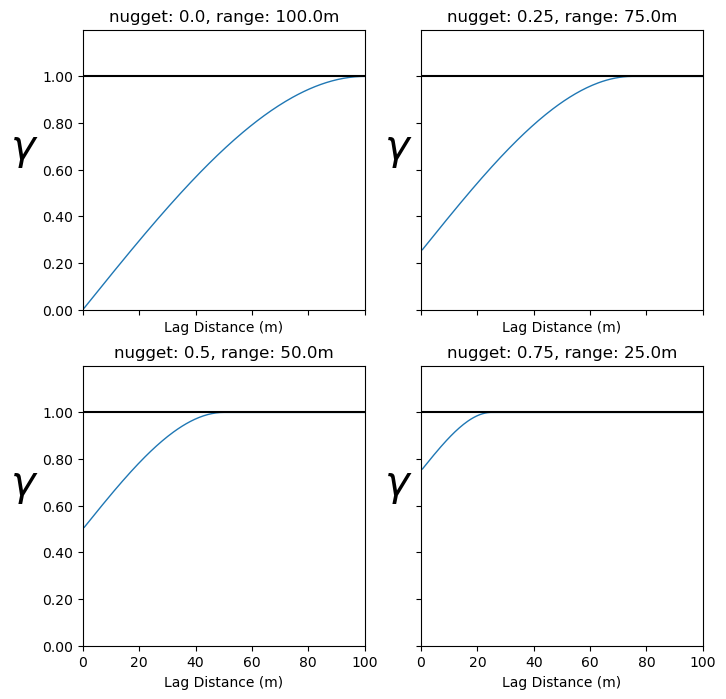

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
for vario, ax, name in zip(varios, axes.flat, vario_names):
    vario.plot(ax=ax, xlim=(0, 100), title=name)

Create DGMs using a $(15m)^3$ block and the variogram models defined above, storing a list of the associated block-scale distributions. Note that the discretization in the z direction corresponds with number of vertical composite lengths in the block size.

A diffuse model is used here, but a mosaic model could be used alternatively when appropriate for a given mineralization style.

In [9]:
block_dists = []
for vario in varios:
    dgm = rmsp.histscale.DGMDiffusionCorrection(
        vario=vario,
        blocksize=[15] * 3,
        num_discret=[5, 5, 3],
    ).scale_histogram(data['CU'], wt=data['wt'])[1]
    block_dists.append(rmsp.UniStats(dgm, name='CU'))

Plot the block distributions as histograms and associated statistics (mean and variance), showing that greater variogram continuity leads to relatively close reproduction of the point-scale distribution (red KDE line and statistics), whereas reduced continuity leads to increasing convergence towards the mean. This is visualized using the block histogram and reinforced by the displayed block variance. Note that the point-scale and block-scale means match across all results, as expected.

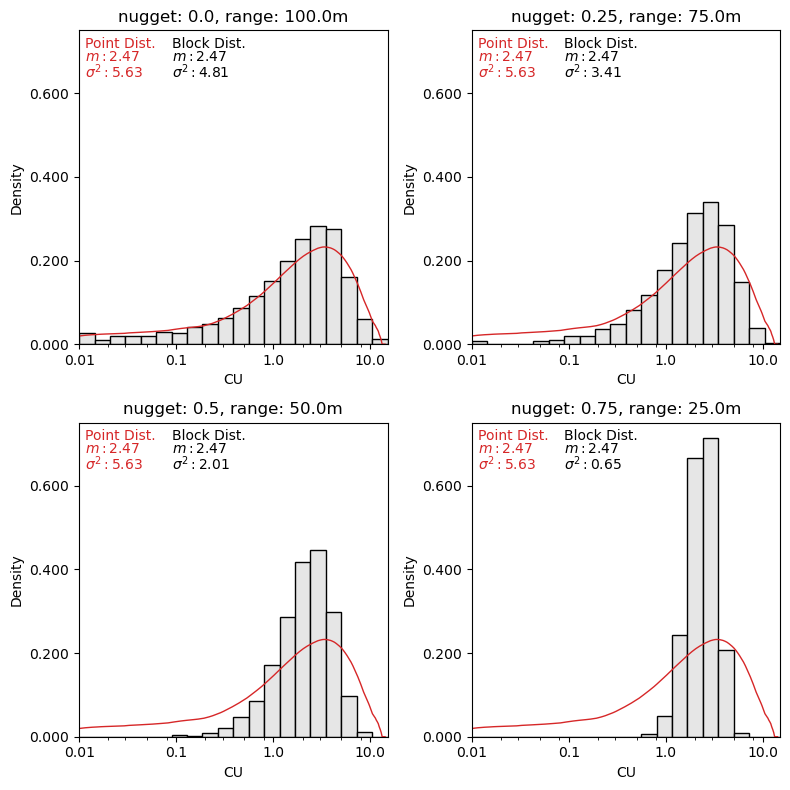

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for block_dist, vario_name, ax in zip(block_dists, vario_names, axes.flat):
    plot_point_vs_block_dists(point_dist, block_dist, vario_name, ax, 0.75)
fig.tight_layout()

---
# Impact of Block Size on Block Distribution

Create a list of cubic block sizes to use:

In [11]:
block_sizes = [5, 15, 30, 60]

Generate a DGM using different block sizes, storing a list of the associated block distributions. A 0.25 nugget effect and 75m range variogram (defined in the prior section) is utilized for all all results. The changing discretization in the z direction corresponds with number of vertical composite lengths in the growing block size.

In [12]:
block_dists = []
for block_size in block_sizes:
    dgm = rmsp.histscale.DGMDiffusionCorrection(
        vario=varios[1],
        blocksize=[block_size] * 3,
        num_discret=[5, 5, int(block_size / 5.0)],
    ).scale_histogram(data['CU'], wt=data['wt'])[1]
    block_dists.append(rmsp.UniStats(dgm, name='CU'))

Plot the block distributions as histograms and associated statistics (mean and variance), showing that smaller blocks lead to relatively close reproduction of the point-scale distribution, whereas larger blocks lead to increasing convergence towards the mean. This is visualized using the variogram and reinforced by the display block variance. Note that the point-scale and block-scale means match across all results, as expected.

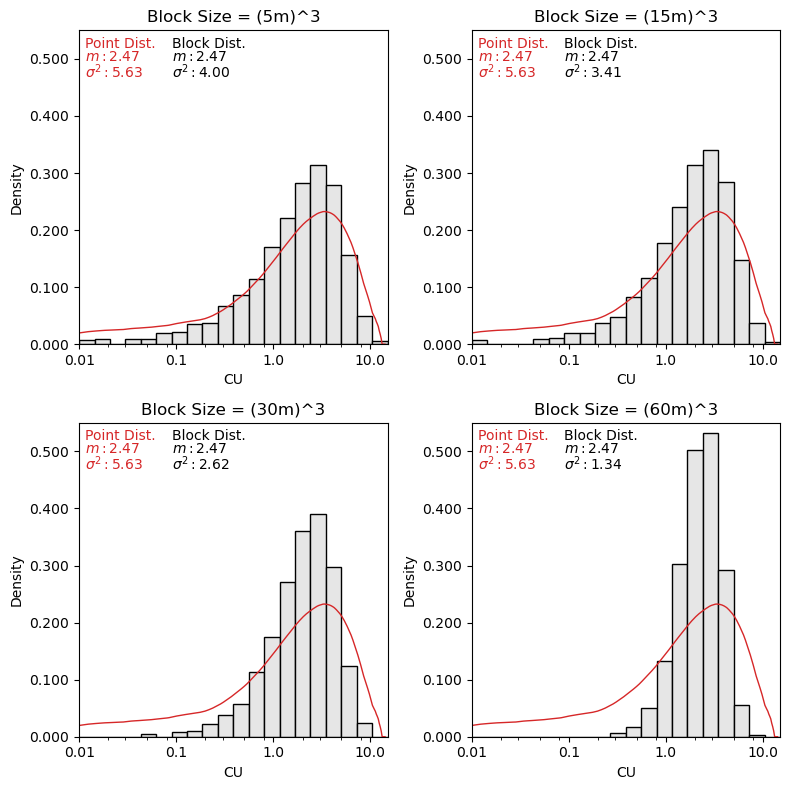

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for block_dist, block_size, ax in zip(block_dists, block_sizes, axes.flat):
    title = f'Block Size = ({block_size}m)^3'
    plot_point_vs_block_dists(point_dist, block_dist, title, ax, 0.55)
fig.tight_layout()

---
# Closing Comments
This notebook demonstrates concepts introduced in the Geostatistics Lesson on Change of Support and the Volume Variance Relation. It illustrates that the variogram and block size have a large impact on the predicted block-scale distribution, which may be rapidly and easily calculated. This permits potential sensitivity testing of parameters under consideration, such as the nugget effect or differing selective mining units under consideration.

Note that the DGM would be calculated in practice with a directional variogram model that is representative of the grades in a domain of interest. The resulting block scale distribution only reflects expected averaging or smoothing of values within a domain, or 'internal dilution'. Averaging that will occur across domain boundaries, or 'contact dilution', is not captured. Predicting contact dilution requires the use of simulation, which is advocated when feasible. Block averaging of simulated point-scale domain/grade realizations will capture both internal and contact dilution, while simultaneously reflecting local conditioning. This provides a superior change of support forecast, although the DGM approach demonstrated here remains a powerful and convenient tool.

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>